In [2]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path

import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

In [3]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
zarr_ds

<xarray.Dataset>
Dimensions:          (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time             (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

In [25]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import xarray as xr

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def correct_coordinates(ds, lat, lon):
    corrected_lat = find_nearest(ds['lat'].values, lat)
    corrected_lon = find_nearest(ds['lon'].values, lon)
    return corrected_lat, corrected_lon

def extract_training_data(ds, lat_query, lon_query, variables, start_date, end_date):
    corrected_lat, corrected_lon = correct_coordinates(ds, lat_query, lon_query)

    ds_selected_time = ds.sel(time=slice(start_date, end_date))

    data_arrays = [ds_selected_time[var].sel(lat=corrected_lat, lon=corrected_lon) for var in variables]
    
    df = pd.DataFrame({var: data_arrays[i].values for i, var in enumerate(variables)})

    
    if df.isnull().all().all():
        raise ValueError(f"The selected coordinates ({lat_query}, {lon_query}) correspond to land. Skipping prediction.")
    
    df = df.dropna()
    
    if df.empty:
        raise ValueError("After removing NaN values, no data is left for training. Skipping prediction.")
    
    return df


def train_multivar_model(df, target_variable):
    X = df.drop(columns=[target_variable])
    y = df[target_variable]

    model = LinearRegression().fit(X, y)
    
    return model

def predict_next_5_days(model, df, target_variable):
    X_last = df.drop(columns=[target_variable]).iloc[-1].values.reshape(1, -1)
    predictions = [model.predict(X_last)[0]]
    
    for _ in range(4):
        X_last[0, -2:] = predictions[-1], df["wind_dir"].iloc[-1]
        pred = model.predict(X_last)[0]
        predictions.append(pred)
        
    return predictions

variables = ['CHL', 'air_temp', 'sst', 'wind_dir', 'wind_speed']
# variables = ['sst', 'wind_dir']
df_train = extract_training_data(zarr_ds, 10, 60, variables, '2021-09-01', '2021-09-30')

model = train_multivar_model(df_train, 'sst')

predictions = predict_next_5_days(model, df_train, 'sst')

print("Predicted SST for the next 5 days:", predictions)


Predicted SST for the next 5 days: [299.62662, 297.30215, 297.3128, 297.31277, 297.31277]


/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


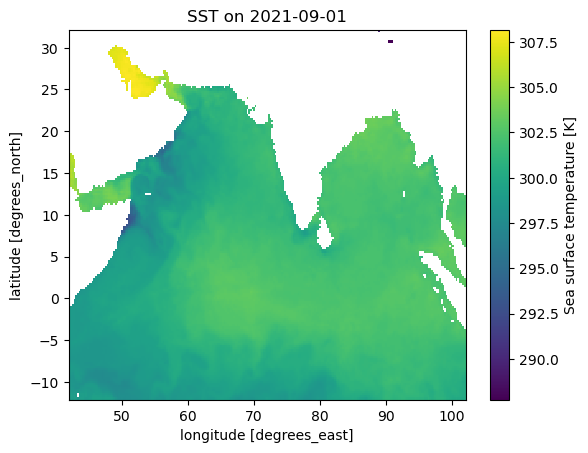

In [14]:
import matplotlib.pyplot as plt
sst_on_first_day = zarr_ds['sst'].sel(time='2021-09-01')

sst_on_first_day.plot()
plt.title("SST on 2021-09-01")
plt.show()

In [26]:
def get_true_data_for_comparison(ds, lat_query, lon_query, start_date, end_date):
    corrected_lat, corrected_lon = correct_coordinates(ds, lat_query, lon_query)
    ds_selected_time = ds.sel(time=slice(start_date, end_date))
    true_sst = ds_selected_time['sst'].sel(lat=corrected_lat, lon=corrected_lon).values
    return true_sst

true_data = get_true_data_for_comparison(zarr_ds, 10, 60, '2021-10-01', '2021-10-05')

comparison = pd.DataFrame({
    'Date': pd.date_range('2021-10-01', '2021-10-05'),
    'Predictions': predictions,
    'True Data': true_data
})

print(comparison)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(true_data, predictions)
print(f"Mean Squared Error: {mse}")


        Date  Predictions   True Data
0 2021-10-01   299.626617  299.786469
1 2021-10-02   297.302155  300.218750
2 2021-10-03   297.312805  300.541656
3 2021-10-04   297.312775  300.343750
4 2021-10-05   297.312775  300.671875
Mean Squared Error: 7.885585784912109
